# Preprocessing countries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random
from datetime import datetime
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import copy

In [2]:
df = pd.read_csv("train_users_2.csv")
df_origin = copy.deepcopy(df)
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


# 1. Evaluating the consistency of the dataset

Are there missing values in the data ?

In [4]:
df.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking          True
gender                     False
age                         True
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked     True
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

**Hence, there are missing values in the columns : **

* date_first_booking : users that never booked an airbnb apartment
* gender : users that didn't wish to specify their gender
* age : to be evaluated
* first_affiliate_tracked : to be evaluated

# 2. Cleaning age 

Ages are represented in two ways in the dataset, some data represent the age and some oters represent the date of birth. 

Also, many irrelevant ages are present or inexistant.

For the relevancy of the data we will only keep users between the age of 15 and 90 years old, and those who specified their age.

A first step is to include users having 2016-age belonging to [15,90] (users that mistook their age with date of birth)
Then the data will be cleaned to remove all users not in the span **[15,90]**, and those **who didn't specify their age**.


In [5]:
#Finding users who put their birthdate instead of age in original dataframe
df_birthyear = df[(df['age']>=1926) & (df['age']<=2001)]

#Converting to age
df_birthyear = copy.deepcopy(df_birthyear)
df_birthyear['age'] = 2016-df_birthyear['age']

#Replacing in original dataframe
df.loc[(df['age']>=1926) & (df['age']<=2001), 'age'] = df_birthyear


#Assigning a -1 value to invalid ages
df = copy.deepcopy(df)
df.loc[((df['age']<15) | (df['age']>90)), 'age'] = -1

#Counting invalid ages
OutOfBoundsAgePercentage = round(100*len(df.loc[(df['age'] == -1), 'age'])/len(df),2)
print('Percentage of users with irrelevant age',OutOfBoundsAgePercentage,'%')

Percentage of users with irrelevant age 1.21 %


We will store the *user_id* of the users who have an invalid age in a new csv file. These users will be deleted. Having the *user_id* in a separate file will allow us to delete the corresponding entries in the file *sessions.csv*

In [6]:
#invalid age
df_invalid_age = df.loc[(df['age']==-1), ['id']]
df = df[df['age'] != -1]

#not specified age
df_invalid_age= pd.concat([df_invalid_age, (df[df['age'].isnull()])])
df.dropna(subset=['age'],inplace = True)

#export
pd.DataFrame(df_invalid_age, columns=list(df_invalid_age.columns)).to_csv('invalid_age_user_id.csv', index=False, encoding="utf-8") 

Plot results

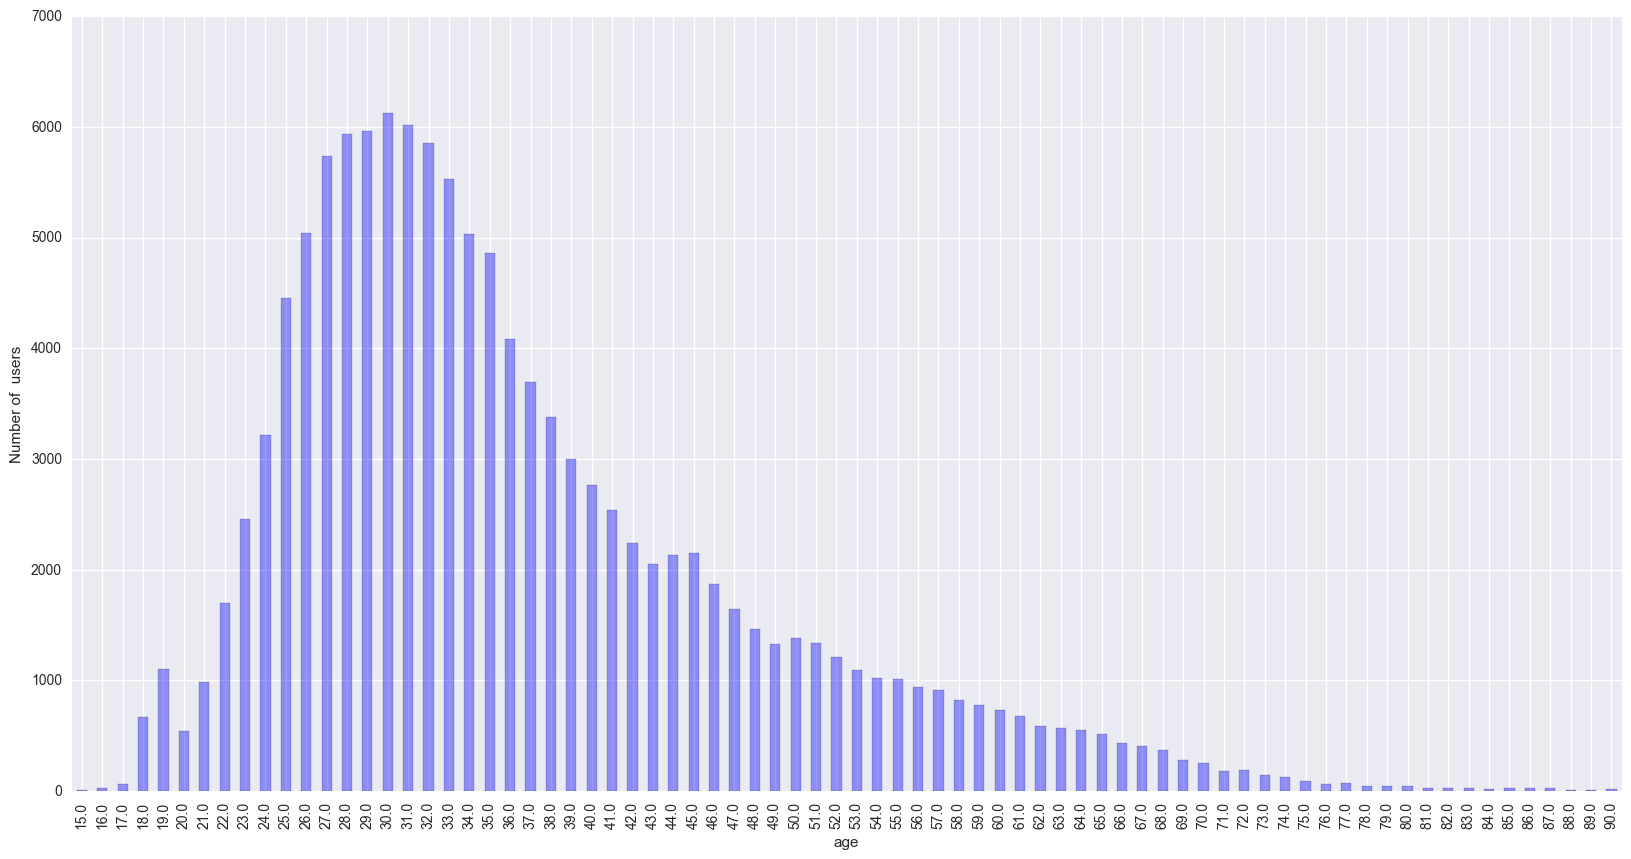

In [7]:
df.id.groupby(df.age).count().plot(kind='bar', alpha=0.4, color='b',figsize=(20,10))
plt.ylabel('Number of  users')
plt.show()

In [8]:
removed = round(100-len(df)/len(df_origin)*100,2)
print('In total,',removed, '% have been removed from the original dataframe')

In total, 42.43 % have been removed from the original dataframe


### Checking NaN values

In [9]:
df.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking          True
gender                     False
age                        False
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked     True
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

# 3. Cleaning the gender feature

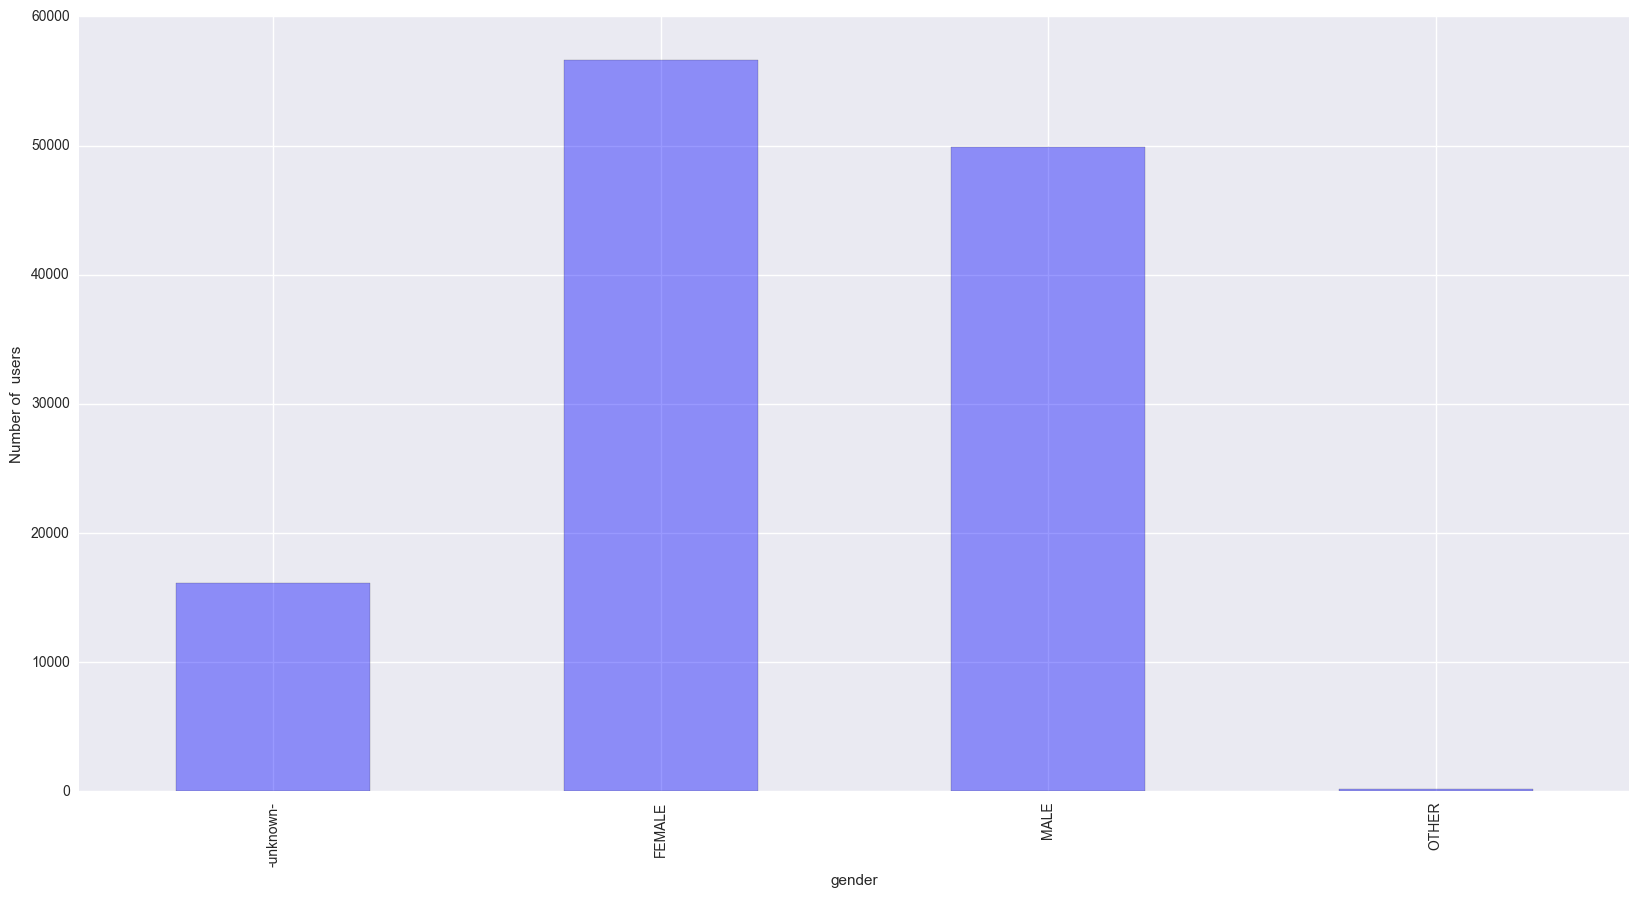

In [10]:
df.id.groupby(df.gender).count().plot(kind='bar', alpha=0.4, color='b',figsize=(20,10))
plt.ylabel('Number of  users')
plt.show()

In [11]:
print(df.gender.value_counts())

FEMALE       56651
MALE         49897
-unknown-    16114
OTHER          225
Name: gender, dtype: int64


We merge the categories unknown and other into unknown

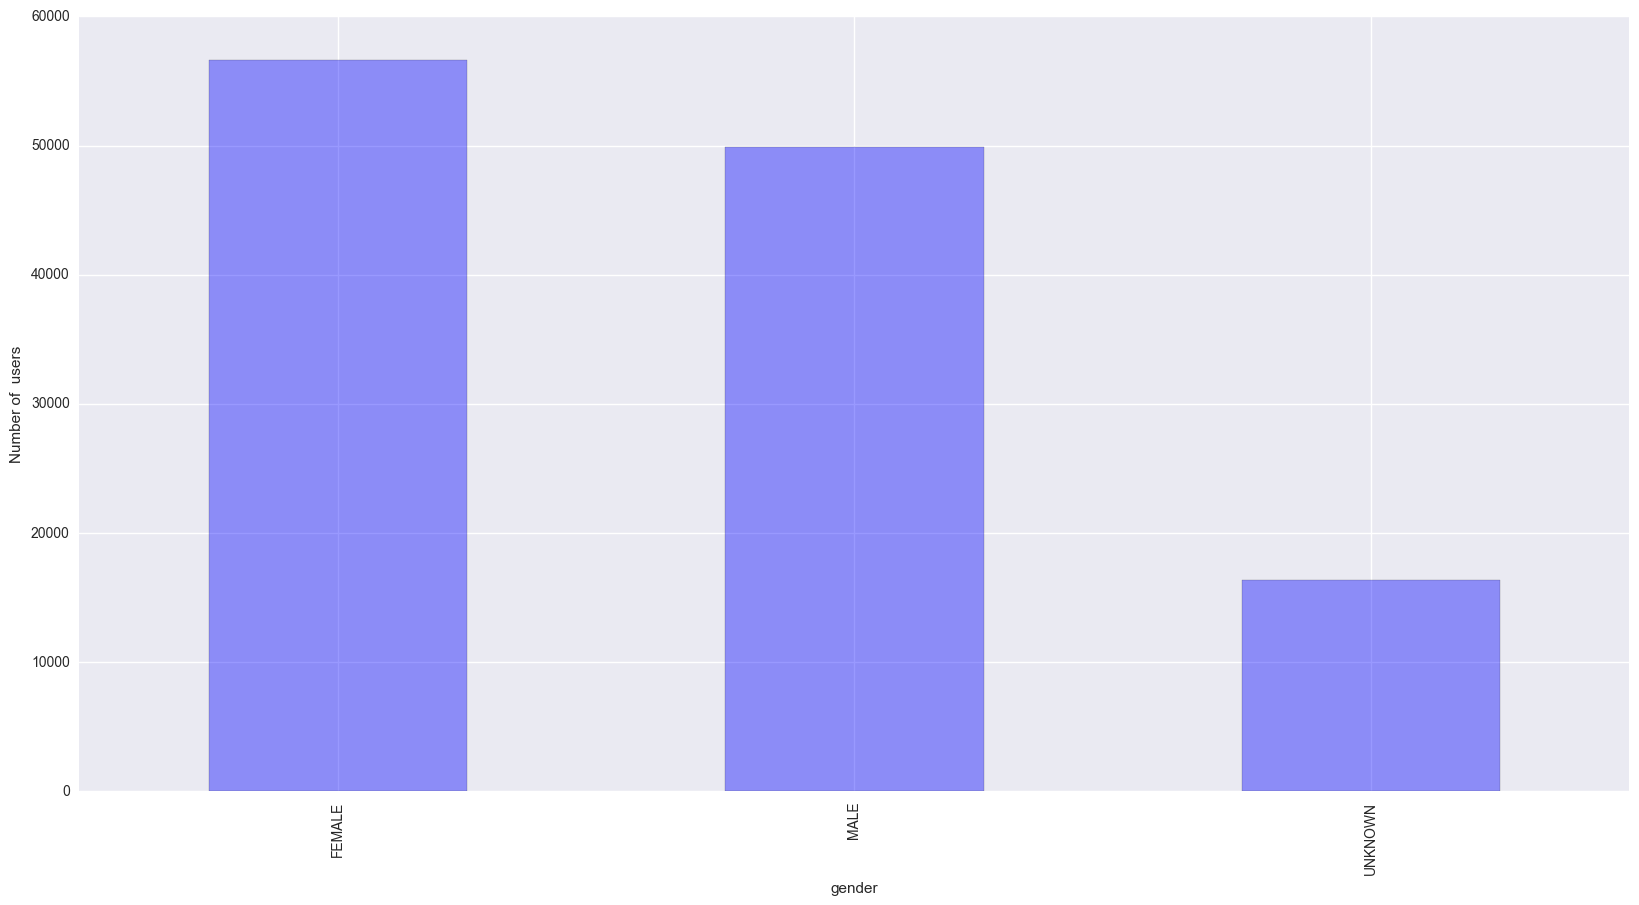

In [12]:
df.loc[df['gender']=='-unknown-', 'gender'] = 'UNKNOWN'
df.loc[df['gender']=='OTHER', 'gender'] = 'UNKNOWN'
df.id.groupby(df.gender).count().plot(kind='bar', alpha=0.4, color='b',figsize=(20,10))
plt.ylabel('Number of  users')
plt.show()

# 4. Cleaning the first_affiliate_tracked feature

This columns represents "whats the first marketing the user interacted with before the signing up", see DATA.md

In [13]:
print(df.first_affiliate_tracked.value_counts())

untracked        63864
linked           27869
omg              24509
tracked-other     3757
product            800
marketing          101
local ops           26
Name: first_affiliate_tracked, dtype: int64


There are NaN values. These NaN values will be merge into the untracked category.

In [14]:
df.loc[df['first_affiliate_tracked'].isnull(), 'first_affiliate_tracked'] = 'untracked'

Plot first_affiliate_tracked

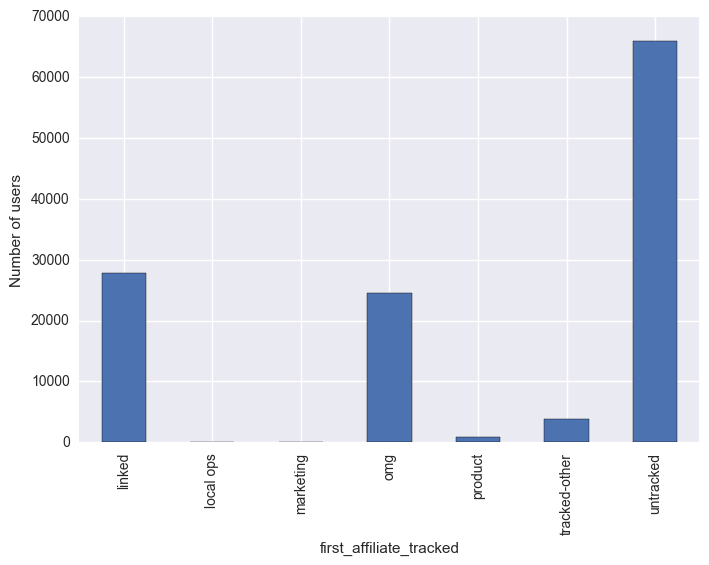

In [15]:
df.id.groupby(df.first_affiliate_tracked).count().plot(kind="bar")
plt.ylabel('Number of users')

### Checking NaN values

In [16]:
df.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking          True
gender                     False
age                        False
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked    False
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

# 5. Language

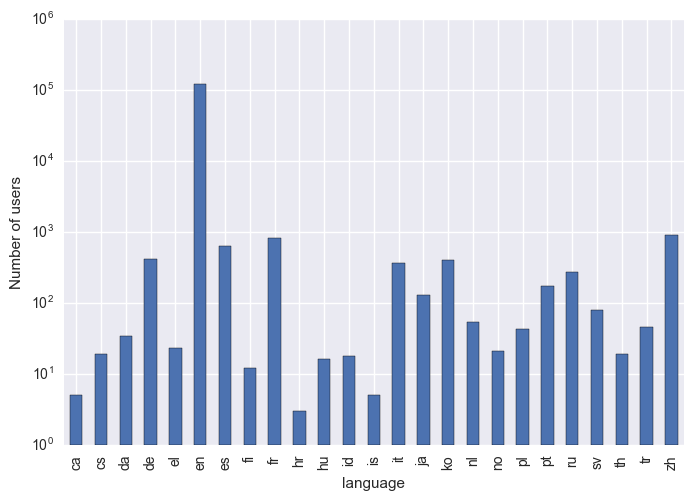

In [17]:
df.id.groupby(df.language).count().plot(kind="bar",log=True)
plt.ylabel('Number of users')

In [18]:
print(df.language.value_counts())

en    118427
zh       907
fr       809
es       631
de       410
ko       396
it       358
ru       269
pt       170
ja       128
sv        78
nl        53
tr        45
pl        42
da        33
el        22
no        20
cs        18
th        18
id        17
hu        15
fi        11
is         4
ca         4
hr         2
Name: language, dtype: int64


# 7. Studying the date_account_created feature

In [19]:
def convert_time2(row):
    return datetime.strptime(row['date_account_created'], '%Y-%m-%d')

df['date_account_created'] = df.apply(convert_time2, axis=1)

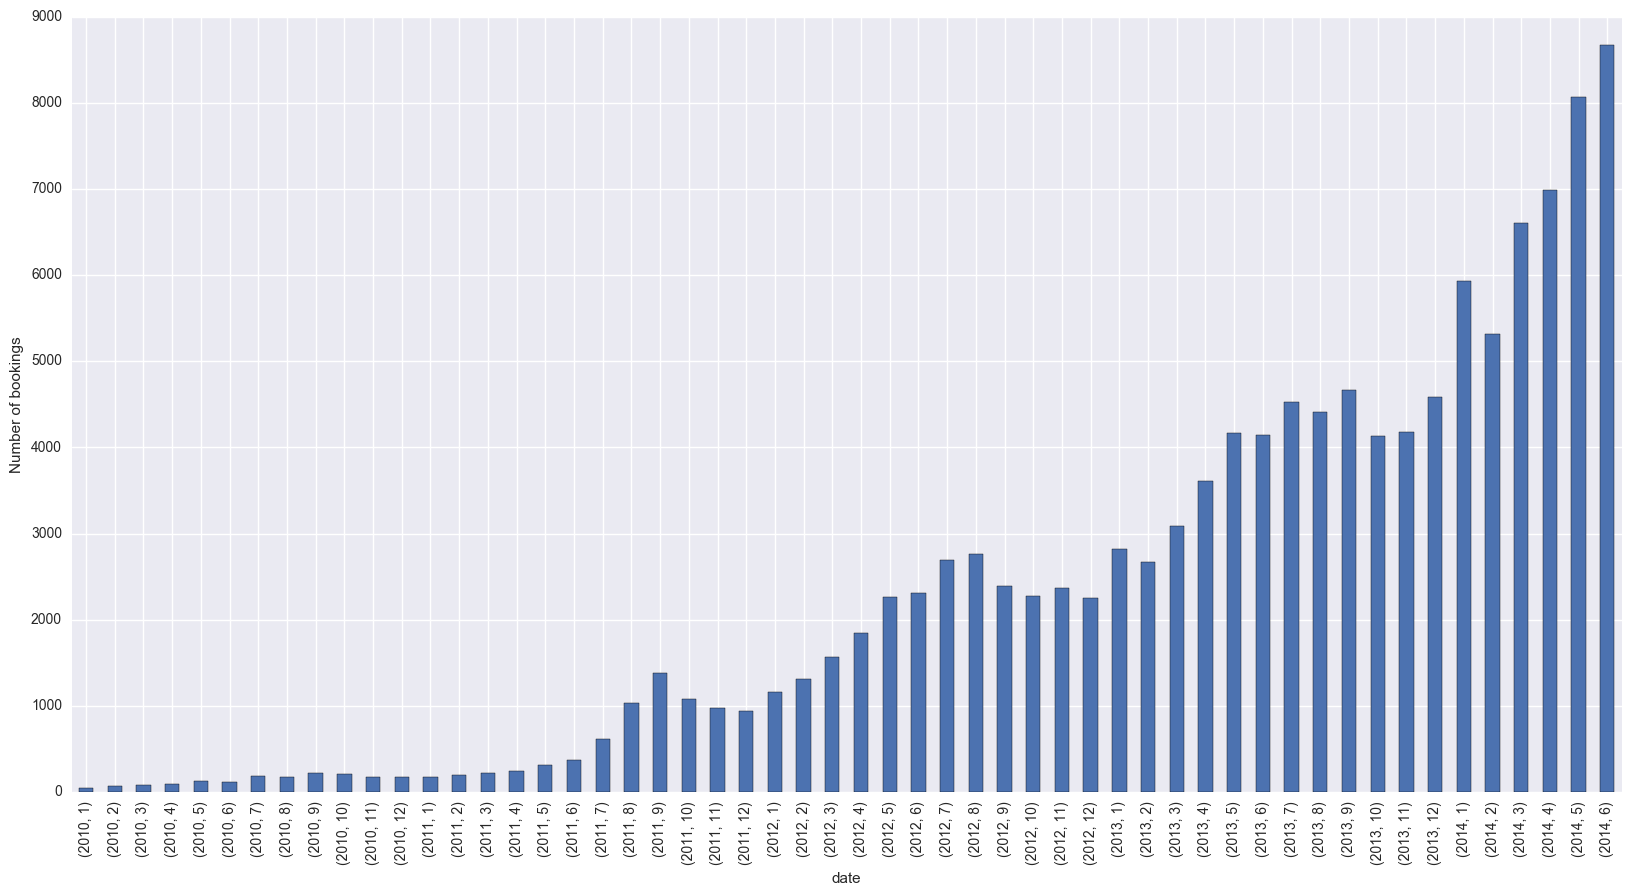

In [20]:
df.id.groupby([df.date_account_created.dt.year, df.date_account_created.dt.month]).count().plot(kind="bar",figsize=(20,10))
plt.xlabel('date')
plt.ylabel('Number of bookings')

## Correlation between the date where the account was created and the first booking

In [23]:
def convert_time(row):
    return datetime.strptime(row['date_first_booking'], '%Y-%m-%d')

In [24]:
df_timecorr = copy.deepcopy(df)
df_timecorr = df_timecorr.dropna(how='any',subset=['date_first_booking']) 

In [25]:
df_timecorr['date_first_booking'] = df_timecorr.apply(convert_time, axis=1)

In [26]:
timediff = pd.DataFrame({'timediff': []})
#for i in df_timecorr.index:
 #   timediff[i,'timediff'] = df_timecorr['date_first_booking'][i]-df_timecorr['date_account_created'][i]
#print(timediff)

In [27]:
timediff['timediff'] = np.round((df_timecorr['date_first_booking'] - df_timecorr['date_account_created']).dt.days).astype(np.int16)

#df.id.groupby(df_timecorr.date_first_booking - df_timecorr.date_account_created).count().plot(kind="bar",figsize=(20,10))
#plt.xlabel('date')
print(timediff)

        timediff
2            -57
3            278
4           -208
6              3
7             10
8            206
9              0
10             2
15             1
17             2
19             0
21             1
22             0
25             3
27            10
28             0
29             6
30            10
36             0
41             2
45             4
49             1
52             1
54             1
55           185
58             0
64             1
74             7
75             1
76           190
...          ...
213343         9
213350        38
213351         1
213352         1
213356        15
213358         4
213360       242
213370         1
213372       287
213378         4
213384       190
213385       145
213388       244
213390         8
213398         1
213400        35
213401        15
213402       288
213405       199
213406         1
213407         0
213408         8
213409        12
213410       211
213412       207
213415         0
213439       2

# Testing cells below

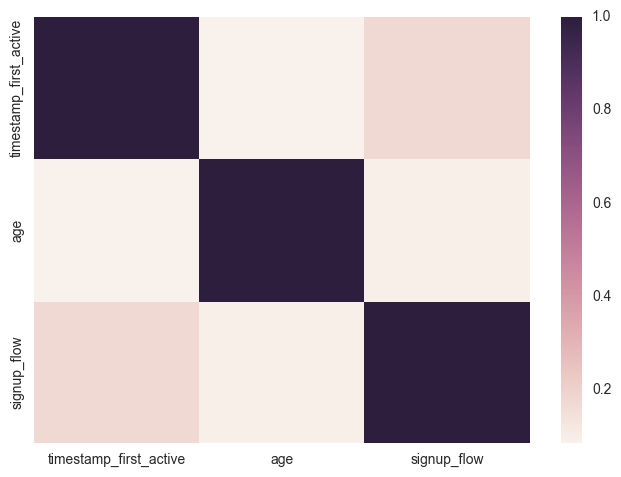

In [28]:
corr = np.abs(df.corr())
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# 3. Cleaning the date_first_booking column

In [29]:
NonBookersPercentage = df['date_first_booking'].isnull().sum()/len(df)
print('Percentage of non bookers',round(NonBookersPercentage*100,2),'%')

Percentage of non bookers 45.35 %


More than half of the dataset holds non booker users

We split the dataset in 2 parts: The users who have booked and the users who have not booked.

In [30]:
#Dataset users not booked yet
df_not_booked = df[df['date_first_booking'].isnull()]
print('Number of users in df_not_booked',len(df_not_booked))

#Dataset users booked yet
df_booked = df.dropna(how='any',subset=['date_first_booking']) 
print('Number of users in df_booked',len(df_booked))

Number of users in df_not_booked 55724
Number of users in df_booked 67163


In [31]:
#checking the splitting
NonBookersPercentage1 = df_not_booked['date_first_booking'].isnull().sum()/len(df_not_booked)
NonBookersPercentage2 = df_booked['date_first_booking'].isnull().sum()/len(df_booked)

print('Percentage of non-bookers in df_not_booked',round(NonBookersPercentage1*100,2),'%')
print('Percentage of non-bookers in df_booked',round(NonBookersPercentage2*100,2),'%')

Percentage of non-bookers in df_not_booked 100.0 %
Percentage of non-bookers in df_booked 0.0 %


### Conversion dat to timestamp format

In [32]:

df_booked = copy.deepcopy(df_booked)
df_booked['date_first_booking'] = df_booked.apply(convert_time, axis=1)

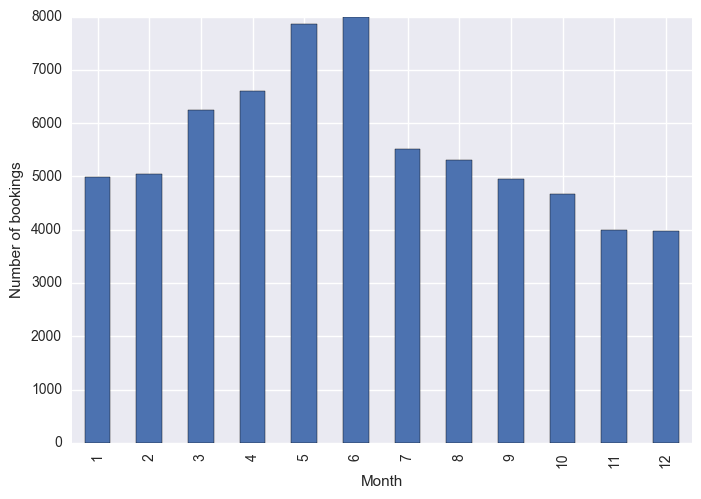

In [33]:
df_booked.id.groupby([df_booked.date_first_booking.dt.month]).count().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('Number of bookings')

It is possible to understand from this histogram that the bookings are pretty well spread over the year. Much less bookings are made during november and december and the months of May and June are the ones where users book the most.